## Covid-19 Deaths Prediction - Time Series

<img src='covid.jpg' width=550 >

## Import Libraries

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [39]:
df=pd.read_csv('COVID19.csv')
#Read the file.

## EDA - Exploratory Data Analysis

In [40]:
df.head()

,Date,Date_YMD,Daily Confirmed,Daily Deceased
0,30 January 2020,2020-01-30,1,0
1,31 January 2020,2020-01-31,0,0
2,1 February 2020,2020-02-01,0,0
3,2 February 2020,2020-02-02,1,0
4,3 February 2020,2020-02-03,1,0


In [41]:
df.shape

(720, 4)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             720 non-null    object
 1   Date_YMD         720 non-null    object
 2   Daily Confirmed  720 non-null    int64 
 3   Daily Deceased   720 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.6+ KB


In [43]:
df.isnull().sum()

Date               0
Date_YMD           0
Daily Confirmed    0
Daily Deceased     0
dtype: int64

In [44]:
df['Date_YMD']=pd.to_datetime(df['Date_YMD'])

In [45]:
df['Day']=df['Date_YMD'].dt.day
df['Month']=df['Date_YMD'].dt.month
df['Year']=df['Date_YMD'].dt.year

In [48]:
df.drop('Date', axis=1, inplace=True)

In [49]:
df.head()

,Date_YMD,Daily Confirmed,Daily Deceased,Day,Month,Year
0,2020-01-30,1,0,30,1,2020
1,2020-01-31,0,0,31,1,2020
2,2020-02-01,0,0,1,2,2020
3,2020-02-02,1,0,2,2,2020
4,2020-02-03,1,0,3,2,2020


## Data Visualization

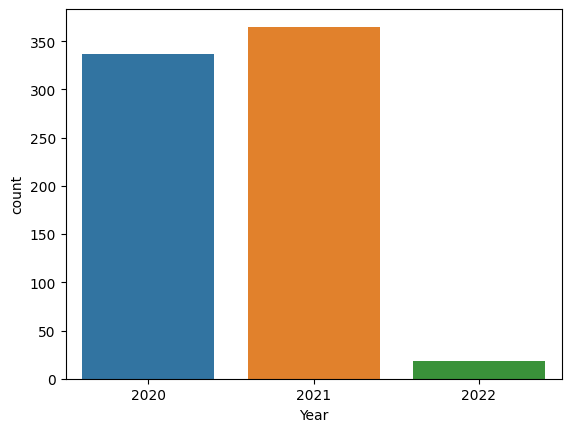

In [51]:
sns.countplot(x=df['Year']);

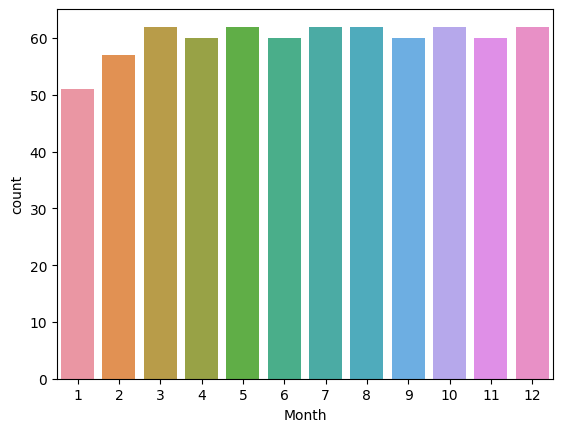

In [52]:
sns.countplot(x=df['Month']);

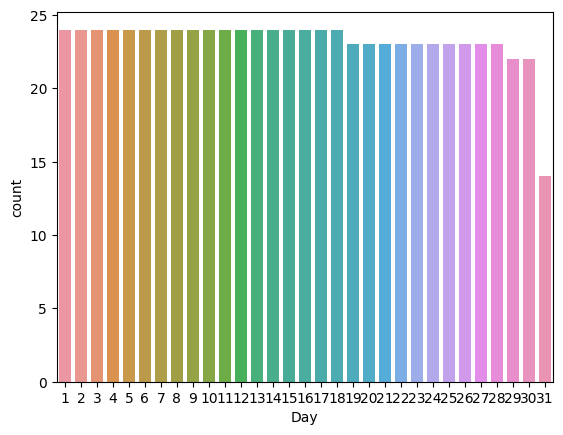

In [53]:
sns.countplot(x=df['Day']);

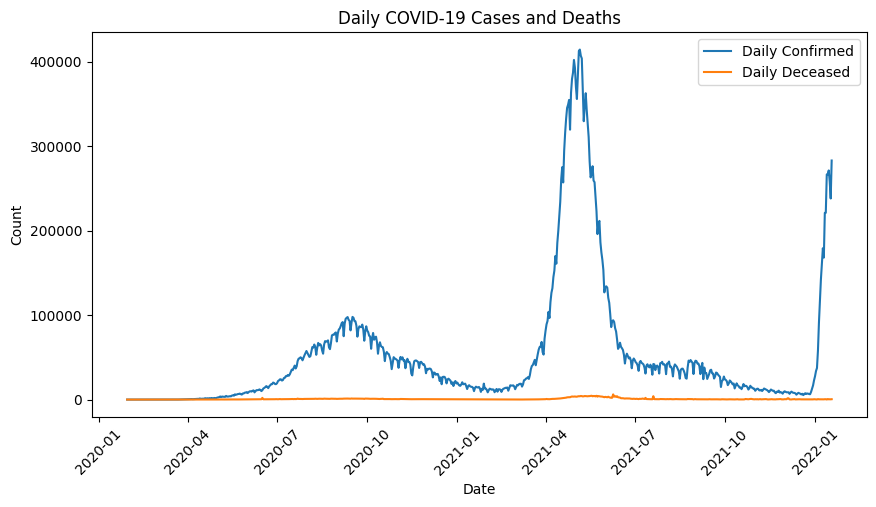

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date_YMD'], df['Daily Confirmed'], label='Daily Confirmed')
plt.plot(df['Date_YMD'], df['Daily Deceased'], label='Daily Deceased')
plt.title('Daily COVID-19 Cases and Deaths')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [55]:
fig = px.bar(df, x='Date_YMD', y='Daily Deceased')
fig.show()

In [56]:
fig = px.bar(df, x='Date_YMD', y='Daily Confirmed')
fig.show()

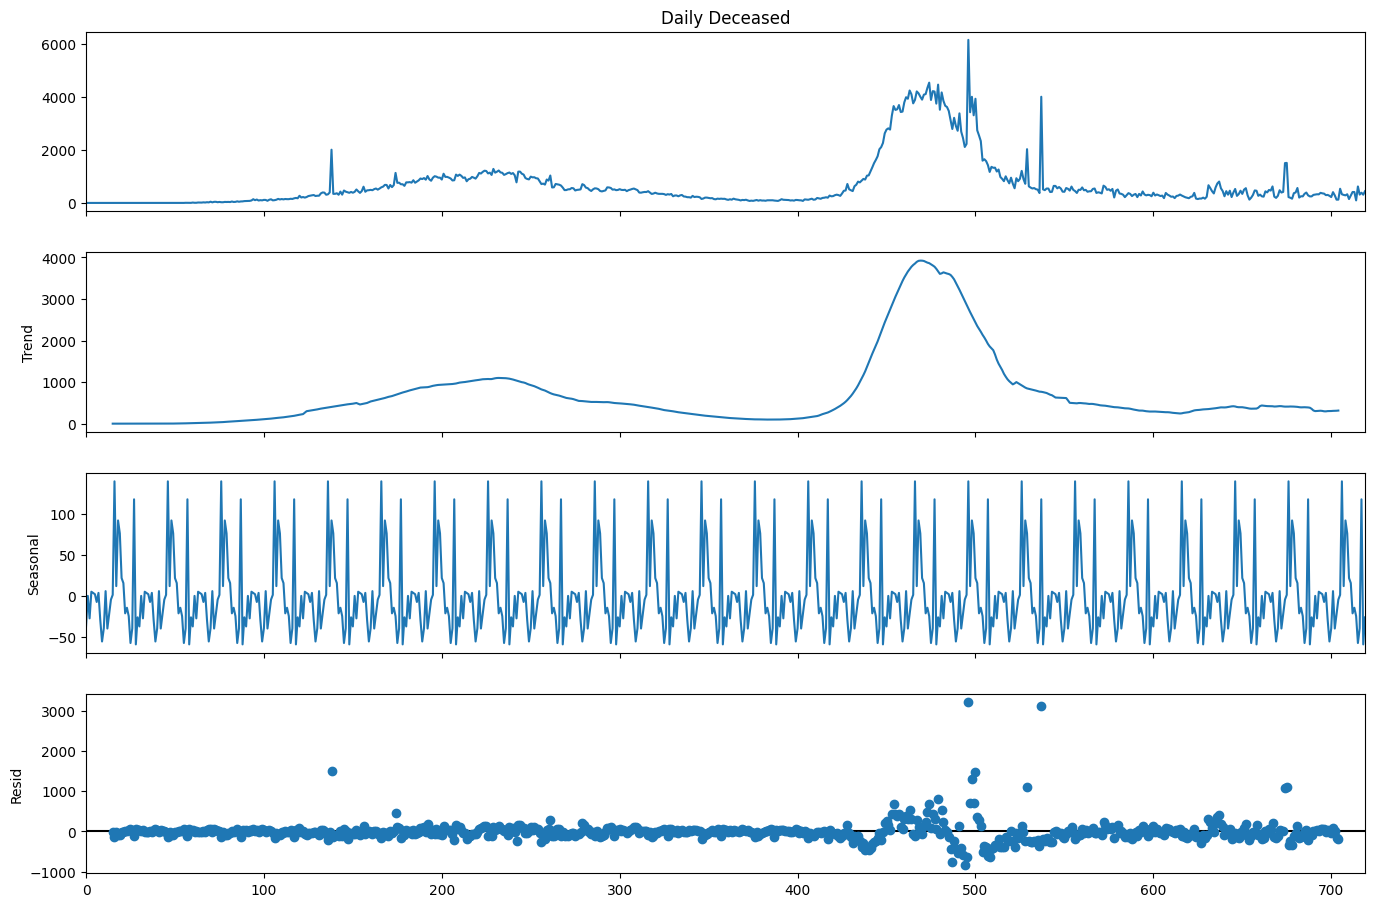

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['Daily Deceased'],model='additive',period=30)
fig=result.plot()
fig.set_size_inches(15,10)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

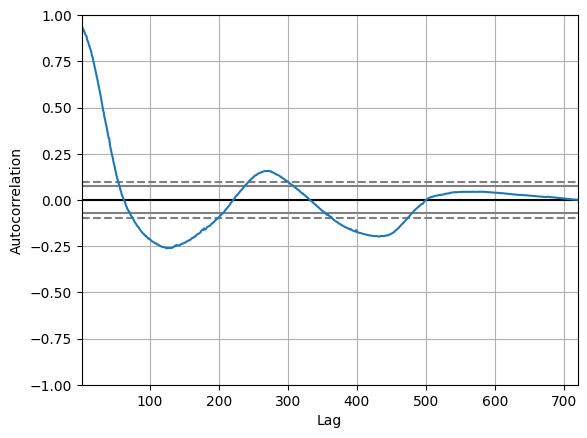

In [21]:
pd.plotting.autocorrelation_plot(df["Daily Deceased"]);

### FINDING P - D - Q - VALUES

In [26]:
#pip install pmdarima

In [66]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [28]:
from pmdarima.arima import auto_arima 
model = auto_arima(df['Daily Deceased'], seasonal=False, suppress_warnings=True)

print("Model Order (p, d, q):", model.order)

Model Order (p, d, q): (0, 1, 1)


### ARIMA

In [69]:
time_series = df.set_index('Date_YMD')['Daily Deceased']  
result = adfuller(time_series)
print('ADF Statistics:', result[0])
print('p-value:', result[1])

differenced_series = time_series.diff().dropna()

ADF Statistics: -2.697489781124056
p-value: 0.07447365473671401


In [74]:
result_differenced = adfuller(differenced_series)
print('ADF Statistics (Differenced):', result_differenced[0])
print('p-value (Differenced):', result_differenced[1])

#Since the time series in our model is not stationary, we take the difference of the series. Then we check it again. 
#Our series has become stationary. We can move on to making predictions for the ARIMA model.

ADF Statistics (Differenced): -5.397945725592961
p-value (Differenced): 3.4210183025061132e-06


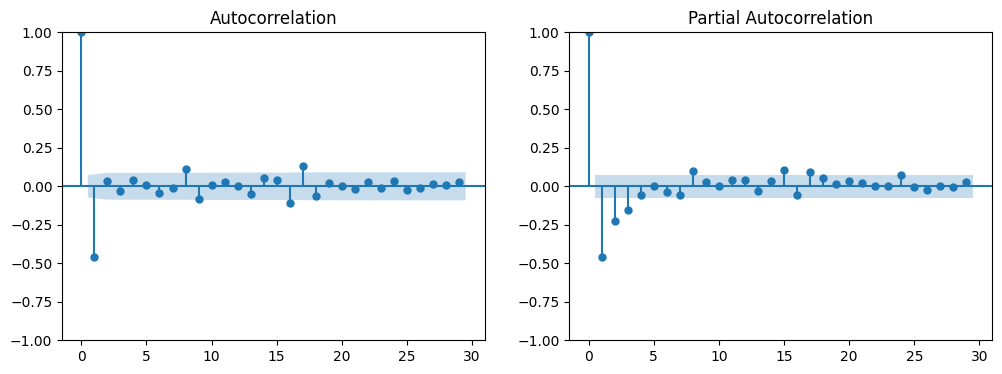

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])  # ACF chart
plot_pacf(differenced_series, ax=axes[1])  # PACF chart (Since our data is very little, we give the lags value 5.)
plt.show()

                               SARIMAX Results                                
Dep. Variable:         Daily Deceased   No. Observations:                  720
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -5063.259
Date:                Mon, 23 Sep 2024   AIC                          10130.518
Time:                        16:48:34   BIC                          10139.674
Sample:                    01-30-2020   HQIC                         10134.053
                         - 01-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5768      0.012    -46.786      0.000      -0.601      -0.553
sigma2      7.706e+04    706.081    109.145      0.000    7.57e+04    7.84e+04
Ljung-Box (L1) (Q):                   0.55   Jarque-

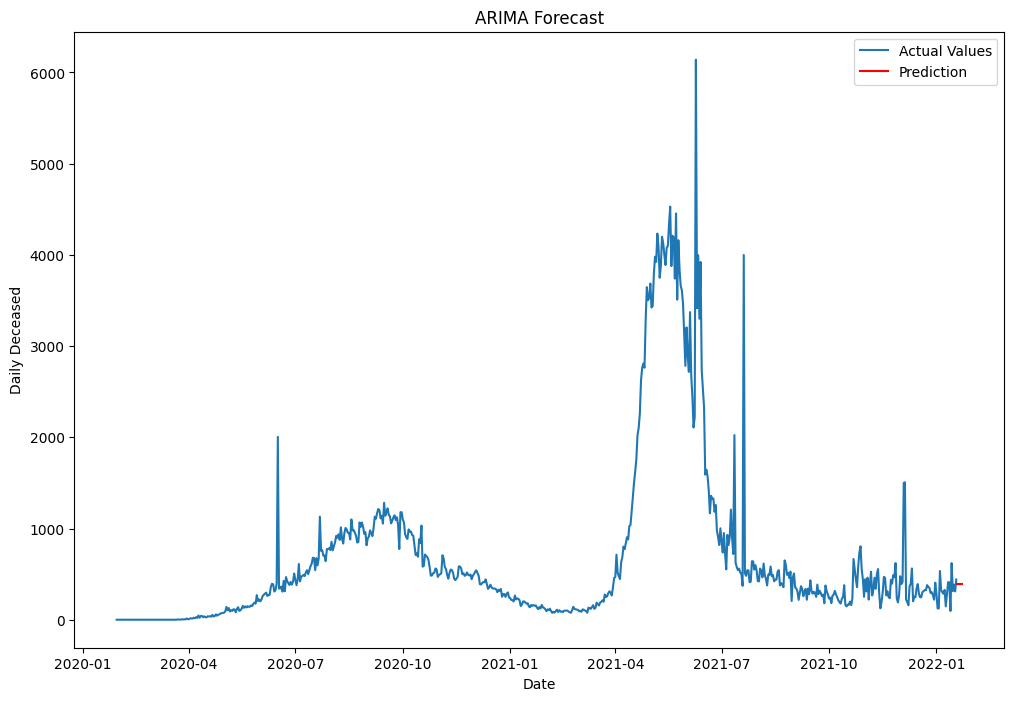

In [79]:
# ARIMA model parameters
p,d,q = 0 , 1 , 1
# We calculated the p,d,q values above.  

# Building an ARIMA model
model = ARIMA(time_series, order=(p, d, q))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Forecasting (Guess 5 steps ahead)
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing forecast results
plt.figure(figsize=(12, 8))
plt.plot(time_series, label='Actual Values')

# Creating forecast dates with due date
forecast_dates = pd.date_range(start=time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Drawing predictions
plt.plot(forecast_dates, forecast, label='Prediction', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Deceased')
plt.legend()
plt.show()

### SARIMA

In [61]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Daily Deceased'])
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Daily Deceased   No. Observations:                  720
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5175.615
Date:                Mon, 23 Sep 2024   AIC                          10355.230
Time:                        16:38:09   BIC                          10364.388
Sample:                             0   HQIC                         10358.765
                                - 720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9595      0.004    233.728      0.000       0.951       0.968
sigma2      1.024e+05    854.592    119.826      0.000    1.01e+05    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                 139.73   Jarque-Bera (JB):            192387.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.86   Skew:                             2.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        82.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
predictions=results.predict(len(df),len(df)+7)
predictions

720    423.125496
721    405.975476
722    389.520577
723    373.732624
724    358.584585
725    344.050522
726    330.105550
727    316.725792
Name: predicted_mean, dtype: float64

<Axes: >

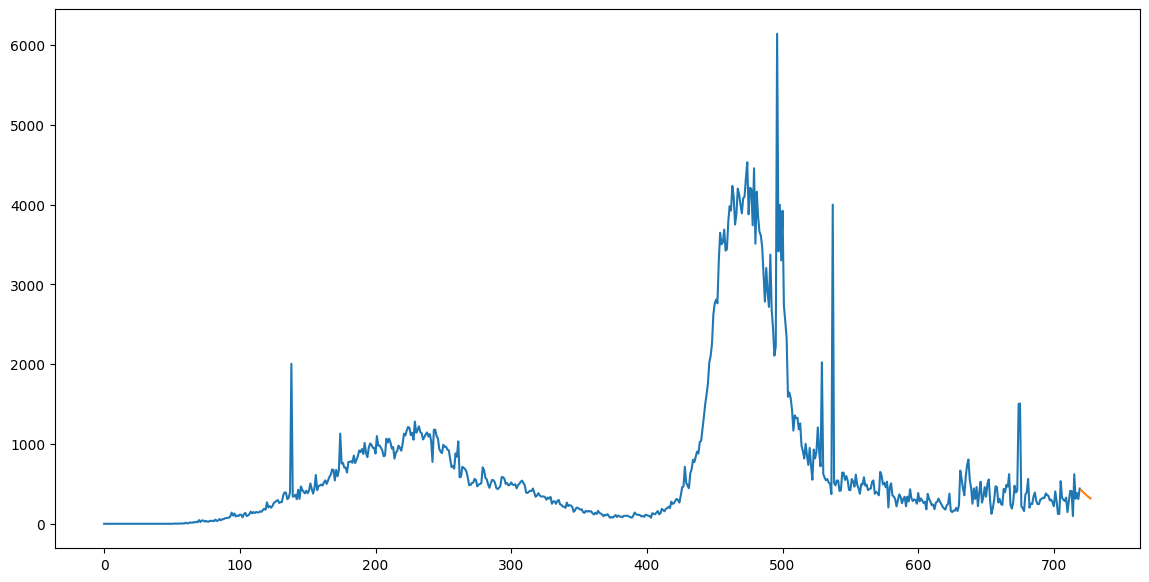

In [63]:
plt.figure(figsize=(14, 7))
df['Daily Deceased'].plot()
predictions.plot()

### Prophet

In [24]:
#pip install prophet

In [29]:
forecast_data=df.rename(columns={'Date_YMD':'ds','Daily Deceased':'y'})

In [30]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
model=Prophet()
model.fit(forecast_data)
forecasts=model.make_future_dataframe(periods=365)
predictions=model.predict(forecasts)
plot_plotly(model,predictions)

21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
